# ANOVA jednostronna test zgodności wariancji

https://reneshbedre.github.io/blog/anova.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('c:/3/test1.txt', sep="\t")
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


Analizujemy tylko jeden czynnik ponieważ interesuje nas jakość leczenia (to ten jedne czynnik) więc wybieramy ANOVA jednokierunkową.

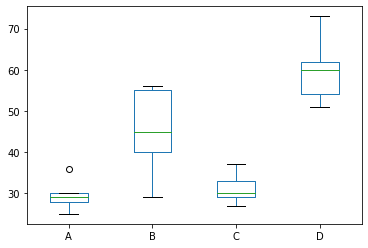

In [2]:
df.boxplot(column=['A', 'B', 'C', 'D'], grid=False)

In [3]:
import scipy.stats as stats
k = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
k

F_onewayResult(statistic=17.492810457516338, pvalue=2.639241146210922e-05)

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [5]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
df_melt.head(3)

,index,variable,value
0,0,A,25
1,1,A,30
2,2,A,28


In [6]:
df_melt.columns = ['index', 'treatments', 'value']
df_melt.head(3)

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28


In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('value ~ C(treatments)', data=df_melt).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq    df         F    PR(>F)
C(treatments)  3010.95   3.0  17.49281  0.000026
Residual        918.00  16.0       NaN       NaN


Interpretacja : Wartość P uzyskana z analizy ANOVA jest znacząca (P <0,05), a zatem wnioskujemy, że istnieją znaczące różnice między sposobami leczenia.

### Testu HSD Tukeya

In [8]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_melt['value'], groups=df_melt['treatments'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  A      B      15.4    1.6929  29.1071  True 
  A      C      1.6    -12.1071 15.3071 False 
  A      D      30.4   16.6929  44.1071  True 
  B      C     -13.8   -27.5071 -0.0929  True 
  B      D      15.0    1.2929  28.7071  True 
  C      D      28.8   15.0929  42.5071  True 
----------------------------------------------


Powyższe wyniki z Tukey HSD sugerują, że oprócz AC, wszystkie inne porównania par w leczeniu odrzucają hipotezę zerową i wskazują na istotne różnice statystyczne w leczeniu.

### Sprawdzenie spełnienia warunków ANOVA
Warunki: 
1. wartości rezydualne mają rozkład normalny (test Shapiro Wilksa)
2. wariancje w grupach są jednorodne (test Levene lub Bartlett)
3. obserwacje są prowadzone niezależnie od siebie 

### Sprawdzenie jednorodności wariancji
Test Levene'a można wykorzystać do sprawdzenia jednorodności wariancji . 
> ##### Hipoteza zerowa : próbki z populacji mają równe wariancje.

In [9]:
import scipy.stats as stats
w,p = stats.levene(df['A'], df['B'], df['C'], df['D'])
print("Value:   ",w)
print("p-value: ",p)

Value:    1.9219593192195938
p-value:  0.16673281219949276


Ponieważ wartość P nie jest znacząca (p>0.05), nie odrzucamy hipotezy zerowej - czyli leczenie ma równe wariancje.

### Sprawdzenia rozkładu normalnego reszt

Test Shapiro-Wilka można wykorzystać do sprawdzenia rozkładu normalnego reszt. 

> ##### Hipoteza zerowa : wartości rezydualne mają rozkład normalny.

In [10]:
import scipy.stats as stats
w, p = stats.shapiro(model.resid)
print("Value:   ",w)
print("p-value: ",p)

Value:    0.9685019850730896
p-value:  0.7229772806167603


Ponieważ wartość P nie jest znacząca (p>0.05), nie odrzucamy hipotezy zerowej - czyli wartości rezydualne mają rozkład normalny.

## Sprawdzamy czy poziom insuliny we krwi pacjętek różni się zależnie od wieku.

Analizujemy tylko jeden czynnik ponieważ interesuje nas jakość leczenia (to ten jedne czynnik) więc wybieramy ANOVA jednokierunkową.

Źródło danych: https://www.kaggle.com/saurabh00007/diabetescsv

In [11]:
import pandas as pd
df = pd.read_csv('c:/1/diabetes.csv', usecols=['Insulin','Age'])
df.head(3)

,Insulin,Age
0,0,50
1,0,31
2,0,32


Usuwam brakujące dane. Poziom insuliny we krwi nie może wynosić zero, te rekordy usuwamy jako nie nadające się do naszych testów.

In [12]:
import numpy as np

df['Insulin']=df['Insulin'].replace(0,np.nan)
df = df.dropna(how ='any')
df.isnull().sum()

Insulin    0
Age        0
dtype: int64

Dzielimy paciętki na cztery grupy zależnie od ich wieku.

In [13]:
df['Age_G']=pd.qcut(df['Age'], 4,labels=["young","adults","middle-aged","old"])

In [14]:
df.head()

,Insulin,Age,Age_G
3,94.0,21,young
4,168.0,33,middle-aged
6,88.0,26,adults
8,543.0,53,old
13,846.0,59,old


### <span style="color:blue">Test ANOVA</span>

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model2 = ols('Insulin ~ C(Age_G)', data=df).fit()

anova_table = sm.stats.anova_lm(model2, typ=2)
print(anova_table)

                sum_sq     df         F    PR(>F)
C(Age_G)  2.065342e+05    3.0  5.030065  0.001973
Residual  5.337793e+06  390.0       NaN       NaN


Interpretacja : Wartość P uzyskana z analizy ANOVA jest znacząca (P <0,05), a zatem wnioskujemy, że istnieje istotna statystycznie różnica między poziomem insuliny we krwi pomiędzy wymienionymi czterema grupami wiekowymi.

ANOVA pokazałe, że istnieje statystycznie istotna różnice w poziomie insuliny pomiędzy grupami wiekowymi pacjętek. Niestety ANOVA nie wskazuje, które grupy wiekowe istotnie różnią się od siebie. 

Aby poznać pary grup wiekowych różniące się istotnie poziomem insuliny we krwi, należy przeprowadzić analizę wielokrotnego porównania par (porównanie post-hoc) za pomocą testu HSD Tukeya .


### <span style="color:blue">Testu HSD Tukeya</span>

In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df['Insulin'], groups=df['Age_G'], alpha=0.05)
print(m_comp)

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1      group2   meandiff  lower    upper  reject
--------------------------------------------------------
   adults   middle-aged 38.6753  -4.6784   82.029 False 
   adults       old     54.9994  11.5281  98.4706  True 
   adults      young     4.8819  -37.3082 47.0721 False 
middle-aged     old     16.3241  -27.5906 60.2388 False 
middle-aged    young    -33.7933 -76.4403  8.8536 False 
    old        young    -50.1174 -92.8839  -7.351  True 
--------------------------------------------------------


Test Tukey HSD wykazał statystycznie istotną różnicę w zawartości insuliny we krwi pomiędzy grypami wiekowymi: "old" i "young" oraz "adults" i "old" 
Powyższe wyniki z Tukey HSD sugerują, że oprócz zestawienia old-young i adults-old, wszystkie inne porównania par zachowują hipotezę zerową czyli w pozostałych grupach nie istnieją istotne różnice statystyczne w zawartości insuliny we krwi.

### Sprawdzenie spełnienia warunków ANOVA
Warunki: 
1. wartości rezydualne mają rozkład normalny (test Shapiro Wilksa)
2. wariancje w grupach są jednorodne (test Levene lub Bartlett)
3. obserwacje są prowadzone niezależnie od siebie 

### <span style="color:blue">Test Levene'a</span> Sprawdzenie jednorodności wariancji

#### Hipoteza zerowa : grupa z populacji mają równe wariancje.

In [17]:
df.head()

,Insulin,Age,Age_G
3,94.0,21,young
4,168.0,33,middle-aged
6,88.0,26,adults
8,543.0,53,old
13,846.0,59,old


In [18]:
DFF = df.reset_index()  

In [19]:
KOT = pd.pivot_table(DFF,index='index',columns='Age_G', values='Insulin')

In [20]:
young=KOT['young'].dropna(how='any')
old=KOT['old'].dropna(how='any')
middleaged=KOT['middle-aged'].dropna(how='any')
adults=KOT['adults'].dropna(how='any')

In [21]:
import scipy.stats as stats
w,p = stats.levene(young,old,middleaged,adults)
print("Value:   ",w)
print("p-value: ",p)

Value:    0.8514514983093309
p-value:  0.46645004212147656


Ponieważ wartość P nie jest znacząca (p>0.05), nie odrzucamy hipotezy zerowej - czyli grupy wiekowe mają jednorodne wariancje.

### <span style="color:blue">Test Shapiro-Wilka </span>Sprawdzenia normalności rozkładu reszt

##### Hipoteza zerowa : wartości rezydualne mają rozkład normalny.

In [22]:
import scipy.stats as stats
w, p = stats.shapiro(model2.resid)
print("Value:   ",w)
print("p-value: ",p)

Value:    0.8003953695297241
p-value:  1.1085818629731166e-21


Ponieważ wartość P nie jest znacząca (p>0.05), nie odrzucamy hipotezy zerowej - czyli wartości rezydualne mają rozkład normalny.

Na końcu możemy zrobić wykres porównujący grupy wiekowe:

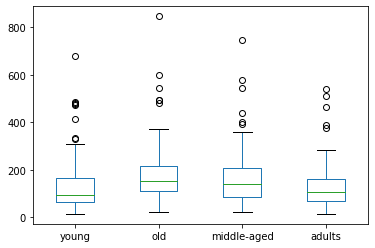

In [23]:
import matplotlib.pyplot as plt
KOT.boxplot(column=['young', 'old', 'middle-aged', 'adults'], grid=False)

# Analiza zanieczyszczenia powietrza substancją PT08.S1(CO) za pomocą ANOVA
- H0: Zanieczyszczenie powietrze PT08.S1(CO) NIE różni sie istotnie w czterech okresach dobowych
- H1: Zanieczyszczenie powietrza PT08.S1(CO) istotnie różni sie w czterech okresach dobowych


Analizujemy tylko jeden czynnik ponieważ interesuje nas jakość leczenia (to ten jedne czynnik) więc wybieramy ANOVA jednostronną.

źródło danych: 

In [24]:
import pandas as pd
df2 = pd.read_csv('c:/TF/AirQ_filled.csv')
df2.head(3)

,Unnamed: 0,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502


In [25]:
df2.dtypes

Unnamed: 0         int64
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Przetwarzamy kolumne Time na format liczbowy.

In [26]:
df2['Time'] = df2.Time.str.slice(0,2)

In [27]:
df2['Time']= df2['Time'].convert_objects(convert_numeric=True) 
df2['Time'].dtype

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


dtype('int64')

### Sprawdzamy kompletność danych

In [28]:
df2.isnull().sum()

Unnamed: 0       0
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

Wydzielam cztery okresy dobowe.

In [29]:
df2['Periods'] = pd.qcut(df2.Time,4,labels=["0-5","6-12","12-18","18-24"])

In [30]:
df2.dtypes

Unnamed: 0          int64
Date               object
Time                int64
CO(GT)            float64
PT08.S1(CO)       float64
C6H6(GT)          float64
PT08.S2(NMHC)     float64
NOx(GT)           float64
PT08.S3(NOx)      float64
NO2(GT)           float64
PT08.S4(NO2)      float64
PT08.S5(O3)       float64
T                 float64
RH                float64
AH                float64
Periods          category
dtype: object

Sprawdzam czasy okresów dobowych.

In [31]:
pd.pivot_table(df2, index='Periods', values='Time', aggfunc=['min', 'max'])

,min,max
,Time,Time
Periods,,
0-5,0,5
6-12,6,11
12-18,12,18
18-24,19,23


Teraz tworzymy tabelę przestawną, gdzie w kolumnch będą cztery okresy dobowe.

In [32]:
PKS = pd.pivot_table(df2, index = 'Date', columns = 'Periods', values='PT08.S1(CO)')
PKS.head(4)

Periods,0-5,6-12,12-18,18-24
Date,,,,
01/01/2005,1119.166667,968.833333,1186.142857,1182.2
01/02/2005,1018.833333,1372.000000,1413.857143,1152.4
01/03/2005,737.666667,827.833333,826.285714,901.4
01/04/2004,1013.666667,1375.000000,1209.428571,1341.8


### Przyjmujemy hipotezy badawcze dla zanieczyszczeń substancją PT08.S1(CO)

- H0: Zanieczyszczenie powietrze PT08.S1(CO) NIE różni sie istotnie w czterech okresach dobowych
- H1: Zanieczyszczenie powietrza PT08.S1(CO) istotnie różni sie w czterech okresach dobowych

### <span style="color:red">Test ANOVA</span>

Zmieniam nazwę PT08.S1(CO) na PT08S1CO.

In [33]:
df2.rename(columns={'PT08.S1(CO)':'PT08S1CO'},inplace=True)

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model3 = ols('PT08S1CO ~ C(Periods)', data=df2).fit()

anova_table = sm.stats.anova_lm(model3, typ=2)
print(anova_table)

                  sum_sq      df           F  PR(>F)
C(Periods)  6.715672e+07     3.0  545.269232     0.0
Residual    3.839796e+08  9353.0         NaN     NaN


Interpretacja : Wartość P uzyskana z analizy ANOVA jest znacząca (P <0,05), a zatem wnioskujemy, że istnieją istotne statystycznie różnice w zanieczyszczeniu powietrza PT08.S1(CO) w czterech okresach dobowych.

ANOVA pokazałą, że istnieje statystycznie istotna różnice w poziomie zanieczyszczenia i hipoteza zerowa została odrzucona na rzecz hipotezy alternatywnej. Niestety ANOVA nie wskazuje, które okresy (ewentualnie) różnią się od siebie. 
Dla sprawdzenia i wykrycia istotnych statystycznie różnic należy przeprowadzić analizę wielokrotnego porównania par (porównanie post-hoc) za pomocą testu HSD Tukeya.

### <span style="color:red">Testu HSD Tukeya</span>

In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df2['PT08S1CO'], groups=df2['Periods'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
 0-5   12-18  188.375  173.7043 203.0456  True 
 0-5   18-24  213.6785 197.715  229.6419  True 
 0-5    6-12  184.4017 169.1811 199.6223  True 
12-18  18-24  25.3035   9.8635  40.7435   True 
12-18   6-12  -3.9733  -18.6439 10.6974  False 
18-24   6-12  -29.2768 -45.2402 -13.3133  True 
-----------------------------------------------


Test HDS Turkeya wskazał, że jedynie porównanie grup: 6-12 z 12-18 nie dała statystycznie istotnych różnic w zanieczyszczeniu PT08.S1(CO). 

### Sprawdzenie spełnienia warunków ANOVA
Warunki: 
1. wartości rezydualne mają rozkład normalny (test Shapiro Wilksa)
2. wariancje w grupach są jednorodne (test Levene lub Bartlett)
3. obserwacje są prowadzone niezależnie od siebie 

### <span style="color:red">Test Levene'a</span> Sprawdzenie jednorodności wariancji

#### Hipoteza zerowa : grupa z populacji mają równe wariancje.

Teraz tworzymy tabelę przestawną, gdzie w kolumnch będą 4 okresy dobowe.

In [36]:
PKS = pd.pivot_table(df2, index = 'Date', columns = 'Periods', values='PT08S1CO')
PKS.head(4)

Periods,0-5,6-12,12-18,18-24
Date,,,,
01/01/2005,1119.166667,968.833333,1186.142857,1182.2
01/02/2005,1018.833333,1372.000000,1413.857143,1152.4
01/03/2005,737.666667,827.833333,826.285714,901.4
01/04/2004,1013.666667,1375.000000,1209.428571,1341.8


In [37]:
P01=PKS['0-5'].dropna(how='any')
P02=PKS['6-12'].dropna(how='any')
P03=PKS['12-18'].dropna(how='any')
P04=PKS['18-24'].dropna(how='any')

In [38]:
import scipy.stats as stats
w,p = stats.levene(P01,P02,P03,P04)
print("Value:   ",w)
print("p-value: ",p)

Value:    30.276341071035155
p-value:  5.0608857455897e-19


Ponieważ wartość P nie jest znacząca (p>0.05), nie odrzucamy hipotezy zerowej - czyli grupy wiekowe mają jednorodne wariancje.

### <span style="color:red">Test Shapiro-Wilk </span>Sprawdzenia normalności rozkładu reszt

##### Hipoteza zerowa : wartości rezydualne mają rozkład normalny.

In [39]:
import scipy.stats as stats
w, p = stats.shapiro(model3.resid)
print("Value:   ",w)
print("p-value: ",np.round(p, decimals=2))

Value:    0.967054009437561
p-value:  0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Ponieważ wartość P wysokości ZERO jest znaczące bo mniejsze od współczynnika ufności 0.05 (p>0.05), odrzucamy hipoteze zerową - wartości rezydualne nie mają rozkładu normalnego.

Przyjrzymy się bliżej resztą modelu.

Zobaczmy jak to wygląda na wykresie.

In [40]:
x=model3.resid
title = "Residuals"
x_label = "level"
y_label = "probability"

In [41]:
def Dist1(x, ax, title, x_label, y_label):
    x.plot.kde(ax=ax, legend=False)
    ax.set_title(title, color='darkred', alpha=1)
    ax.set_ylabel(y_label, color='grey', alpha=0.6)
    ax.set_xlabel(x_label, color='grey', alpha=0.6)

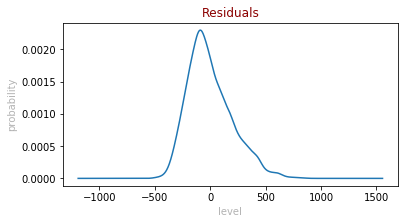

In [42]:
fig, ax = plt.subplots(figsize=(6, 3))
Dist1(x, ax, title, x_label, y_label)

In [43]:
import scipy
scipy.stats.anderson(model3.resid, dist='norm')

AndersonResult(statistic=85.34820578111066, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Tym razem sprawdzimy rozkład normalny reszt za pomocą wykresu QQ.
### Q-Q plot

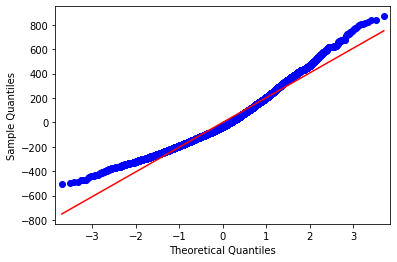

In [44]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

qqplot(model3.resid, line='s')
pyplot.show()

### Jeszcze raz test Shapiro-Wilk 
wykonany z biblioteki scipy.

In [45]:
from scipy.stats import shapiro

stat, p = shapiro(model3.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.967, p=0.000


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Testy K^2 D'Agostino
Test K ^ 2 D'Agostino (Ralpha D'Agostino) oblicza statystyki podsumowujące z danych, mianowicie kurtozę i skośność, aby ustalić, czy rozkład danych odbiega od rozkładu normalnego. Jest to prosty i powszechnie stosowany test statystyczny normalności.

 - Skew (pochylenie) to kwantyfikacja tego, o ile rozkład jest przesuwany w lewo lub w prawo, miara asymetrii w rozkładzie.
 - Kurtosis (skośność) określa ilościowo rozkład ogona. 



In [46]:
from scipy.stats import normaltest

stat, p = normaltest(model3.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=727.597, p=0.000


Test Shapiro-Wilk oraz test K^2 D'Agostino wskazał na zaburzenie normalności rozkładu prawdopodobieństwa wartyości rezydualnych.

Nie potrafie tego skomentować. 

Na końcu wykres porównujący grupy.

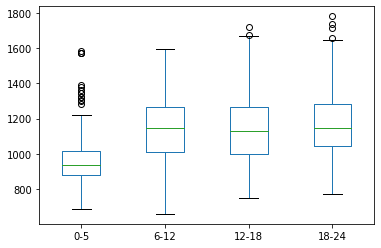

In [47]:
import matplotlib.pyplot as plt
PKS.boxplot(column=['0-5', '6-12', '12-18', '18-24'], grid=False)